- SSI(직렬화 가능 스냅샷 격리)는 버전 9.1부터 SI에 내장되어 진정한 직렬화 가능 격리 수준을 실현
- SSI에 대한 설명은 간단하지 않기 때문에 개요만 설명


- 우선순위 그래프(종속성 그래프 및 직렬화 그래프라고도 함)

- 직렬화 이상(예: Write-Skew)


# **Basic Strategy for SSI Implementation**

- 우선 순위 그래프에 순환이 있으면 직렬화 이상이 발생
  - 이는 가장 간단한 이상 현상인 쓰기 왜곡을 사용하여 설명.
- 그림의 일정에서 Transaction_A는 Tuple_B를 읽고 Transaction_B는 Tuple_A를 읽음.
- 그런 다음 Transaction_A는 Tuple_A를 쓰고 Transaction_B는 Tuple_B를 씀.
- 이 경우 두 개의 rw 충돌이 발생하며 그림 5.12(2)와 같이 이 스케줄의 우선순위 그래프에서 순환을 이룸.
  - 따라서 이 일정에는 직렬화 예외인 Write-Skew가 있음.

**Write-Skew schedule and its precedence graph.**

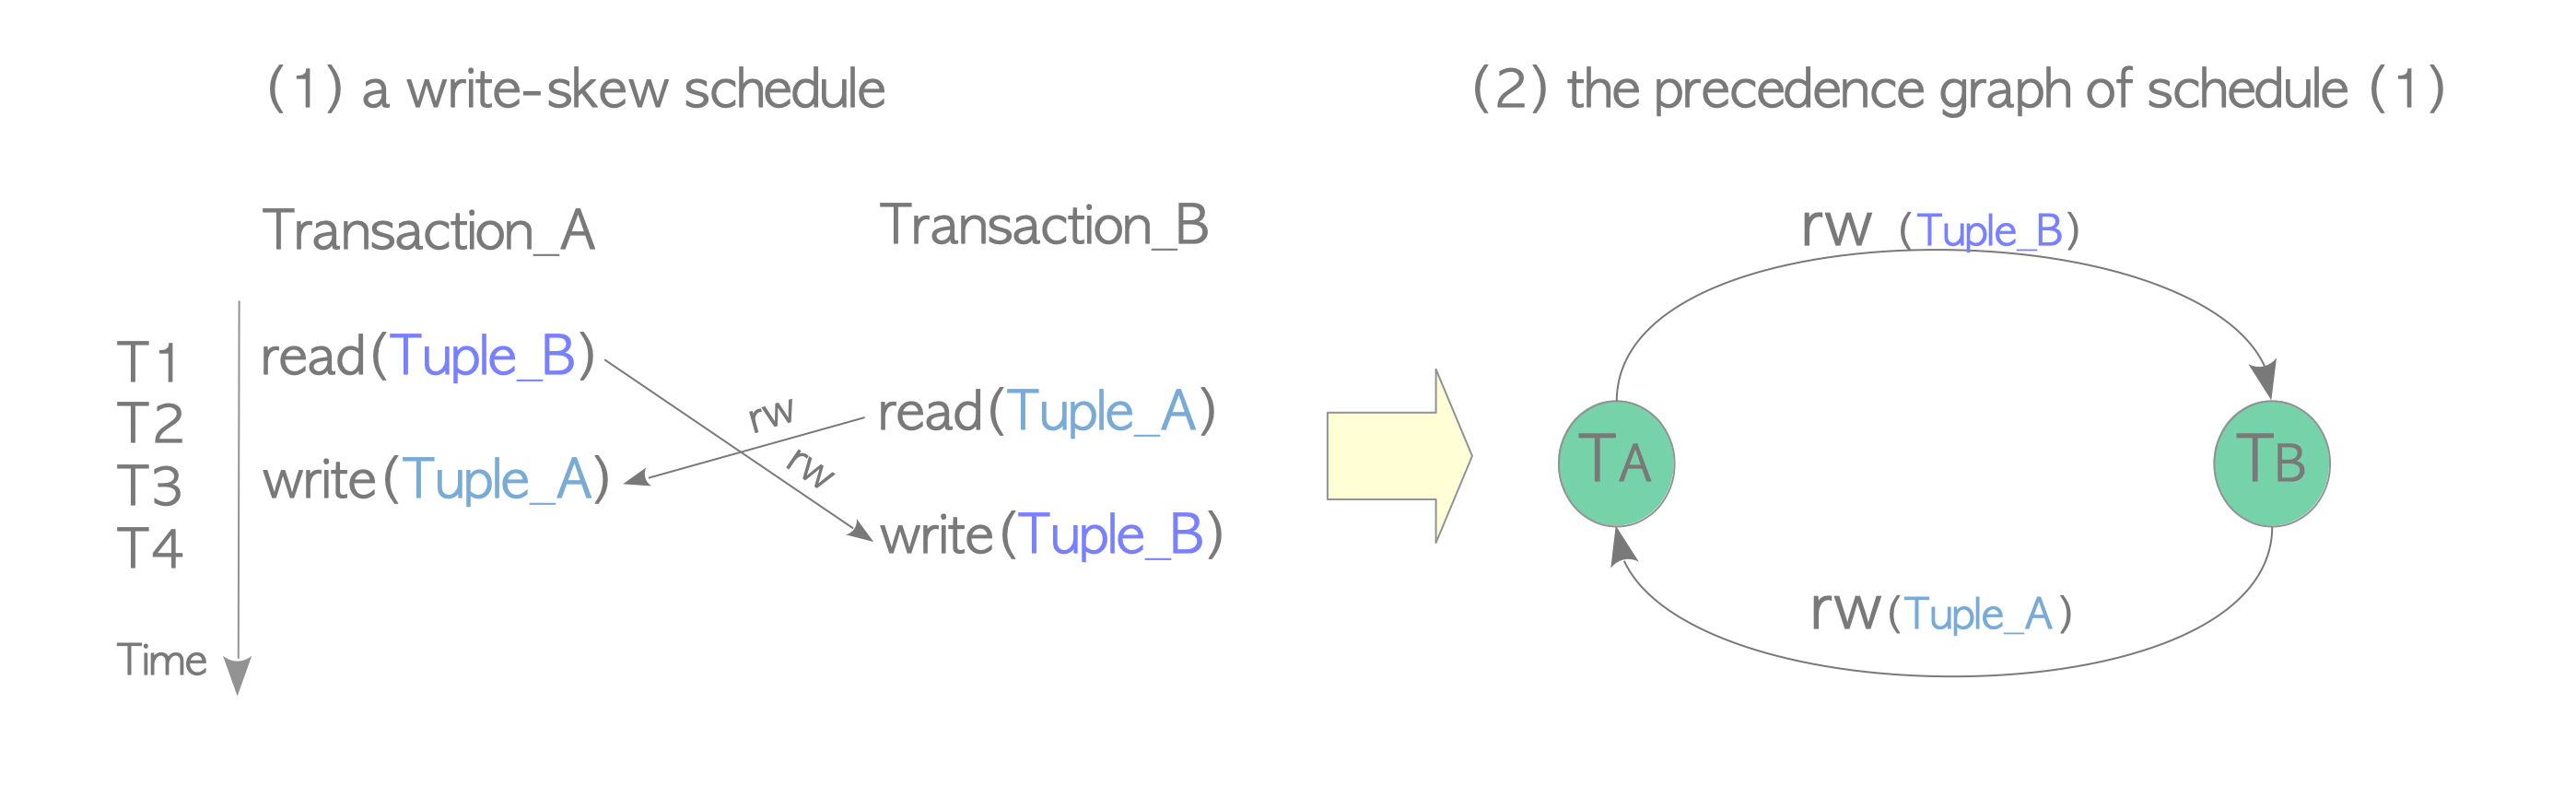

- 개념적으로 conflicts 에는 wr-conflicts (더티 읽기), ww-conflicts (업데이트 손실), rw-conflicts 의 세 가지 유형이 있음.
- 그러나 이전 섹션에서 설명한 것처럼 PostgreSQL은 이러한 conflicts 을 방지하므로 wr 및 ww conflicts 을 고려할 필요가 없음.
- 따라서 PostgreSQL의 SSI 구현에서는 rw conflicts 만 고려하면 됨.

**PostgreSQL은 SSI 구현을 위해 다음 전략을 취함.**

- 트랜잭션이 액세스하는 모든 개체(튜플, 페이지, 관계)를 SIREAD 잠금으로 기록.
- 힙 또는 인덱스 튜플이 기록될 때마다 SIREAD 잠금을 사용하여 rw conflicts 을 감지.
- 감지된 rw conflicts 을 확인하여 직렬화 이상이 감지되면 트랜잭션을 중단.

# **Implementing SSI in PostgreSQL**

- 전략을 실현하기 위해 PostgreSQL은 많은 기능과 데이터 구조를 구현.
  - 그러나 여기서는 SSI 메커니즘을 설명하기 위해 SIREAD 잠금 및 rw-contributes 라는 두 가지 데이터 구조만 사용.[공유 메모리에 저장.]

**Note**
- 단순화를 위해 SERIALIZABLEXACT와 같은 일부 중요한 데이터 구조는 이 문서에서 생략되었음.
- 따라서 CheckForSerializedCon conflictOut, CheckForSerializedCon conflictIn 및 PreCommit_CheckForSerializationFailure 기능에 대한 설명도 매우 단순화됨.

- 예를 들어, 어떤 기능이 conflicts 을 감지하는지 나타냄.
- 그러나 conflicts 이 어떻게 감지되는지는 자세히 설명되지 않음.


**SIREAD 잠금:**
- 내부적으로 조건자 잠금이라고 불리는 SIREAD 잠금은 누가 어떤 개체에 액세스했는지에 대한 정보를 저장하는 개체와 (가상) txid의 쌍.
- 가상 txid에 대한 설명은 생략되. 다음 설명을 단순화하기 위해 가상 txid 대신 txid라는 용어가 사용.

- SIREAD 잠금은 DML 명령이 SERIALIZABLE 모드에서 실행될 때마다 CheckForSerializedCon conflictOut 함수에 의해 생성.
  - 예를 들어 txid 100이 해당 테이블의 Tuple_1을 읽으면 SIREAD 잠금 {Tuple_1, {100}}이 생성.
  - 다른 트랜잭션(예: txid 101)이 Tuple_1을 읽으면 SIREAD 잠금이 {Tuple_1, {100,101}}로 업데이트.
- Index-Only Scans 기능을 적용하면 테이블 페이지를 읽지 않고 인덱스 페이지만 읽기 때문에 인덱스 페이지를 읽을 때에도 SIREAD 잠금이 생성된다는 점에 유의
- SIREAD 잠금에는 튜플, 페이지 및 관계의 세 가지 수준이 있음.
  - 단일 페이지 내의 모든 튜플에 대한 SIREAD 잠금이 생성되면 해당 페이지에 대한 단일 SIREAD 잠금으로 집계되고 연결된 튜플의 모든 SIREAD 잠금이 해제(제거)되어 메모리 공간이 줄어듬.
  - 읽은 모든 페이지에 대해서도 동일.
  - 순차 스캔을 사용하는 경우 인덱스 및/또는 WHERE 절의 유무에 관계없이 관계 수준 SIREAD 잠금이 처음부터 생성.
  - 특정 상황에서는 이 구현으로 인해 직렬화 이상에 대한 잘못된 탐지가 발생할 수 있음.




**rw-conflicts :**
- rw-conflicts 은 SIREAD 잠금의 삼중항과 SIREAD 잠금을 읽고 쓰는 두 개의 txid.
- CheckForSerializedCon conflictIn 함수는 INSERT, UPDATE 또는 DELETE 명령이 SERIALIZABLE 모드에서 실행될 때마다 호출되며 SIREAD 잠금을 확인하여 conflicts 을 감지할 때 rw conflicts 을 생성.
  - 예를 들어, txid 100이 Tuple_1을 읽은 다음 txid 101이 Tuple_1을 업데이트한다고 가정.
  - 이 경우 txid 101의 UPDATE 명령에 의해 호출된 CheckForSerializedCon conflictIn 함수는 txid 100과 101 사이에서 Tuple_1과의 rw conflicts 을 감지한 다음 rw conflicts  {r=100, w=101, {Tuple_1}}을 생성.

- SERIALIZABLE 모드에서 COMMIT 명령이 실행될 때 호출되는 CheckForSerializedCon conflictOut 및 CheckForSerializedCon conflictIn 함수와 PreCommit_CheckForSerializationFailure 함수는 모두 생성된 rw-conflicts 을 사용하여 직렬화 이상을 확인함.
- 이상이 감지되면 첫 번째 커밋된 트랜잭션만 커밋되고 다른 트랜잭션은 중단( first-committer-win 방식에 따름).

# **How SSI Performs**

- 여기에서는 SSI가 Write-Skew 이상 현상을 해결하는 방법을 설명.
- 아래와 같은 간단한 테이블 'tbl'을 사용:



```
testdb=# CREATE TABLE tbl (id INT primary key, flag bool DEFAULT false);
testdb=# INSERT INTO tbl (id) SELECT generate_series(1,2000);
testdb=# ANALYZE tbl;
```

- 트랜잭션 Tx_A 및 Tx_B는 다음 명령을 실행

**Write-Skew scenario.**

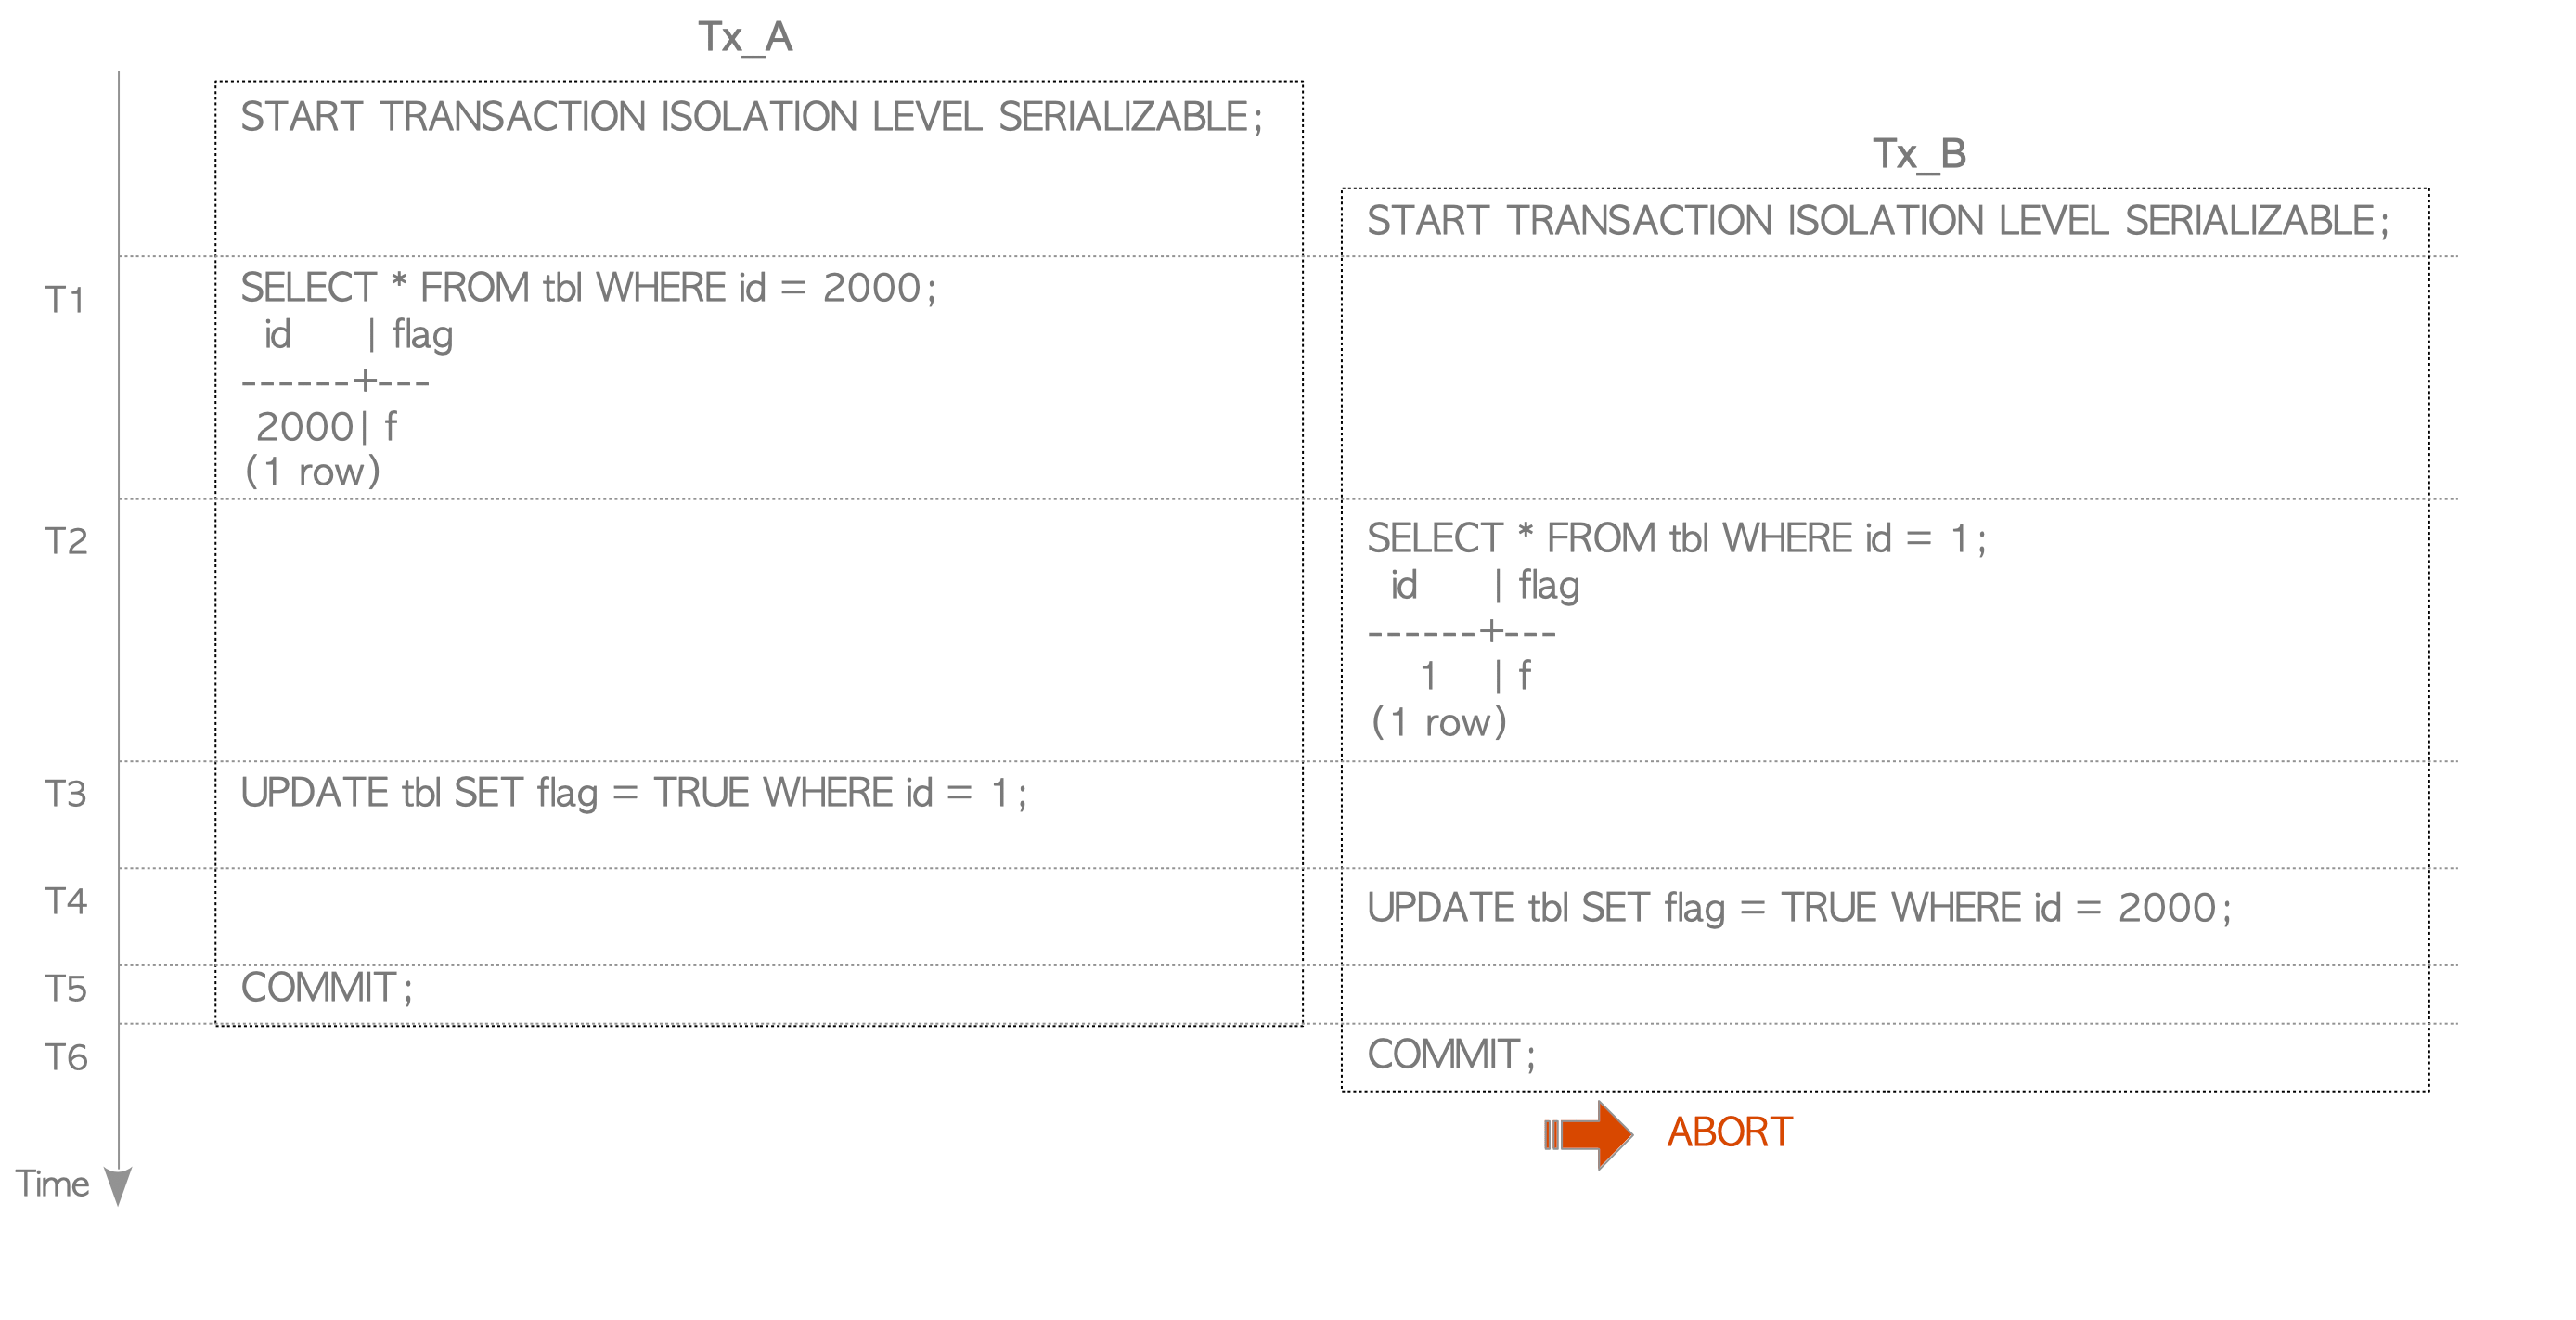

- 모든 명령이 인덱스 스캔을 사용한다고 가정.
- 따라서 명령이 실행되면 힙 튜플과 인덱스 페이지를 모두 읽음.
- 각 페이지에는 해당 힙 튜플을 가리키는 인덱스 튜플이 포함되어 있음



**Relationship between the index and table in the scenario shown**

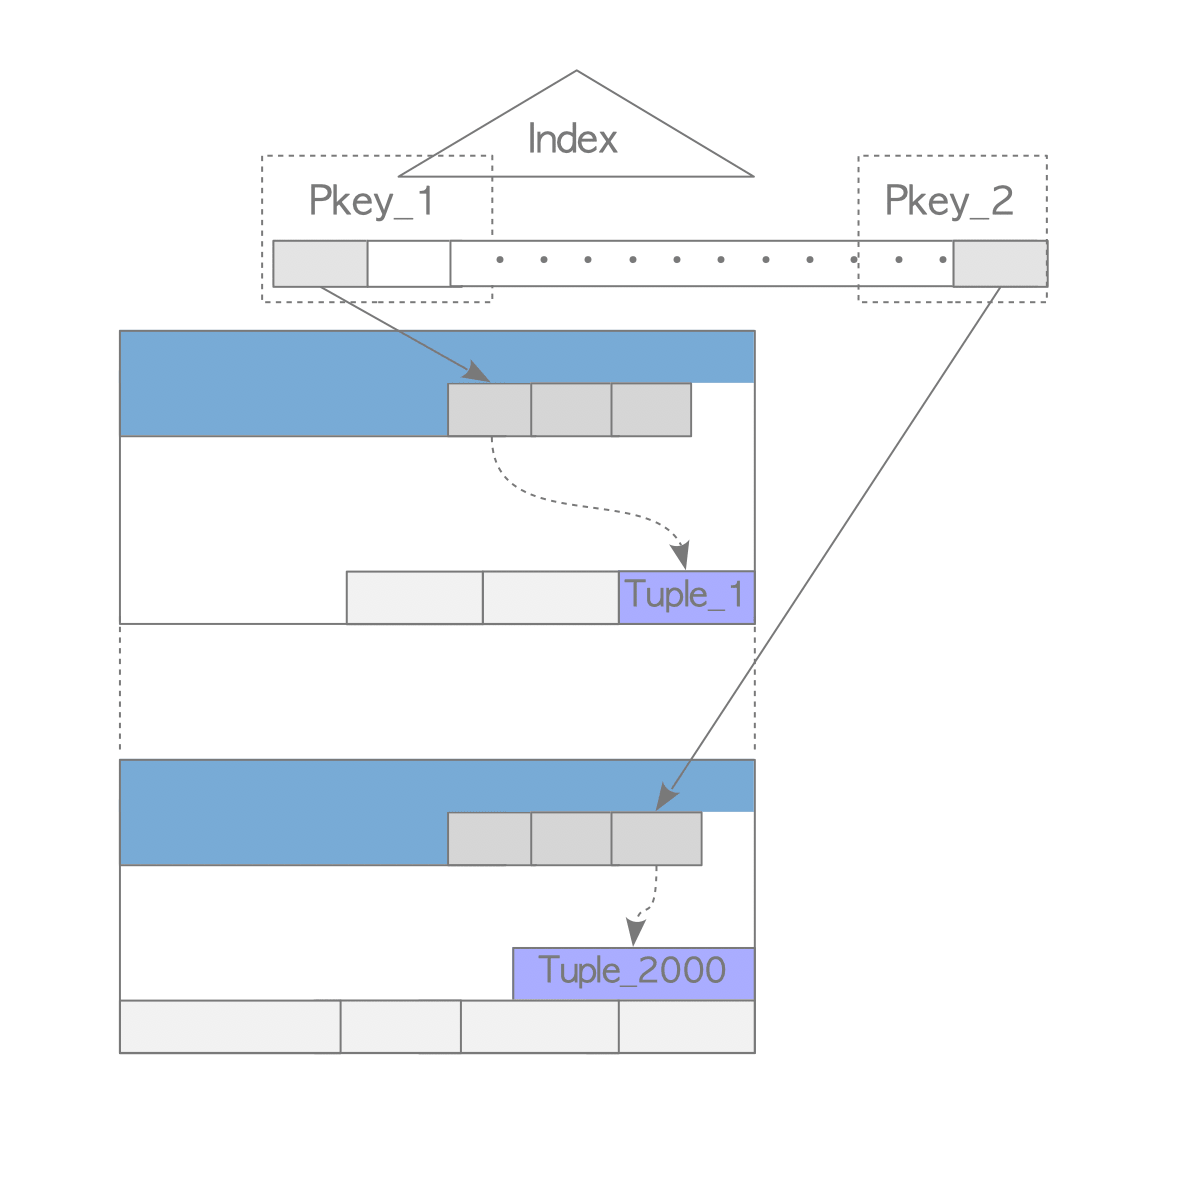

**T1:**
- Tx_A가 SELECT 명령을 실행. 이 명령은 힙 튜플(Tuple_2000)과 기본 키(Pkey_2)의 한 페이지를 읽음.

**T2:**
- Tx_B가 SELECT 명령을 실행. 이 명령은 힙 튜플(Tuple_1)과 기본 키(Pkey_1)의 한 페이지를 읽음.

**T3:**
- Tx_A는 UPDATE 명령을 실행하여 Tuple_1을 업데이트.

**T4:**
- Tx_B는 UPDATE 명령을 실행하여 Tuple_2000을 업데이트.

**T5:**
- Tx_A가 커밋됨.

**T6:**
- Tx_B 커밋; 그러나 Write-Skew 이상으로 인해 중단.

그림은 시나리오에서 설명한 Write-Skew 이상 현상을 PostgreSQL이 감지하고 해결하는 방법을 보여줌.

**SIREAD locks and rw-conflicts, and schedule of the scenario shown**


**T1:**
- Tx_A의 SELECT 명령을 실행하면 CheckForSerializedConflectOut이 SIREAD 잠금을 생성.
- 이 시나리오에서 함수는 두 개의 SIREAD 잠금(L1 및 L2)을 생성.

- L1과 L2는 각각 Pkey_2 및 Tuple_2000과 연결.

**T2:**
- Tx_B의 SELECT 명령을 실행할 때 CheckForSerializedConflectOut은 두 개의 SIREAD 잠금(L3 및 L4)을 생성.

- L3 및 L4는 각각 Pkey_1 및 Tuple_1과 연결.

**T3:**
- Tx_A의 UPDATE 명령을 실행할 때 ExecUpdate 전후에 CheckForSerializedCon conflictOut과 CheckTargetForContricsIN이 모두 호출.

- 이 시나리오에서 CheckForSerializedConflectOut은 아무 작업도 수행하지 않음.

- Pkey_1과 Tuple_1은 모두 Tx_B에서 읽고 Tx_A에서 썼기 때문에 CheckForSerializedCon conflictIn은 Tx_B와 Tx_A 사이에서 Pkey_1과 Tuple_1의 충돌인 rw-con conflict C1을 생성.

**T4:**
- Tx_B의 UPDATE 명령을 실행할 때 CheckForSerializedCon conflictIn은 Tx_A와 Tx_B 사이에서 Pkey_2와 Tuple_2000의 충돌인 rw-con conflict C2를 생성.

- 이 시나리오에서 C1과 C2는 우선순위 그래프에 순환을 생성.
- 따라서 Tx_A 및 Tx_B는 직렬화할 수 없는 상태에 있음.
- 그러나 Tx_A 및 Tx_B 트랜잭션은 모두 커밋되지 않았으므로 CheckForSerializedCon conflictIn은 Tx_B를 중단하지 않음.
- 이는 PostgreSQL의 SSI 구현이 첫 번째 커미터 승리 방식을 기반으로 하기 때문에 발생.

**T5:**
- Tx_A가 커밋을 시도하면 PreCommit_CheckForSerializationFailure가 호출.
- 이 함수는 직렬화 이상을 감지하고 가능한 경우 커밋 작업을 실행할 수 있음.
- 이 시나리오에서는 Tx_B가 아직 진행 중이므로 Tx_A가 커밋.

**T6:**
- Tx_B가 커밋을 시도하면 PreCommit_CheckForSerializationFailure가 직렬화 이상을 감지하고 Tx_A가 이미 커밋되었음.
- 따라서 Tx_B는 중단.

**Other Scenarios**

- 또한, Tx_A가 커밋된 후( T5 에서 ) Tx_B에 의해 UPDATE 명령이 실행되면 Tx_B의 UPDATE 명령에 의해 호출된 CheckForSerializedConflectIn이 직렬화 이상을 감지하므로 Tx_B는 즉시 중단

- T6 에서 COMMIT 대신 SELECT 명령을 실행하면 Tx_B의 SELECT 명령에 의해 호출된 CheckForSerializedConflectOut이 직렬화 이상을 감지하므로 Tx_B가 즉시 중단



**Other Write-Skew scenarios.**

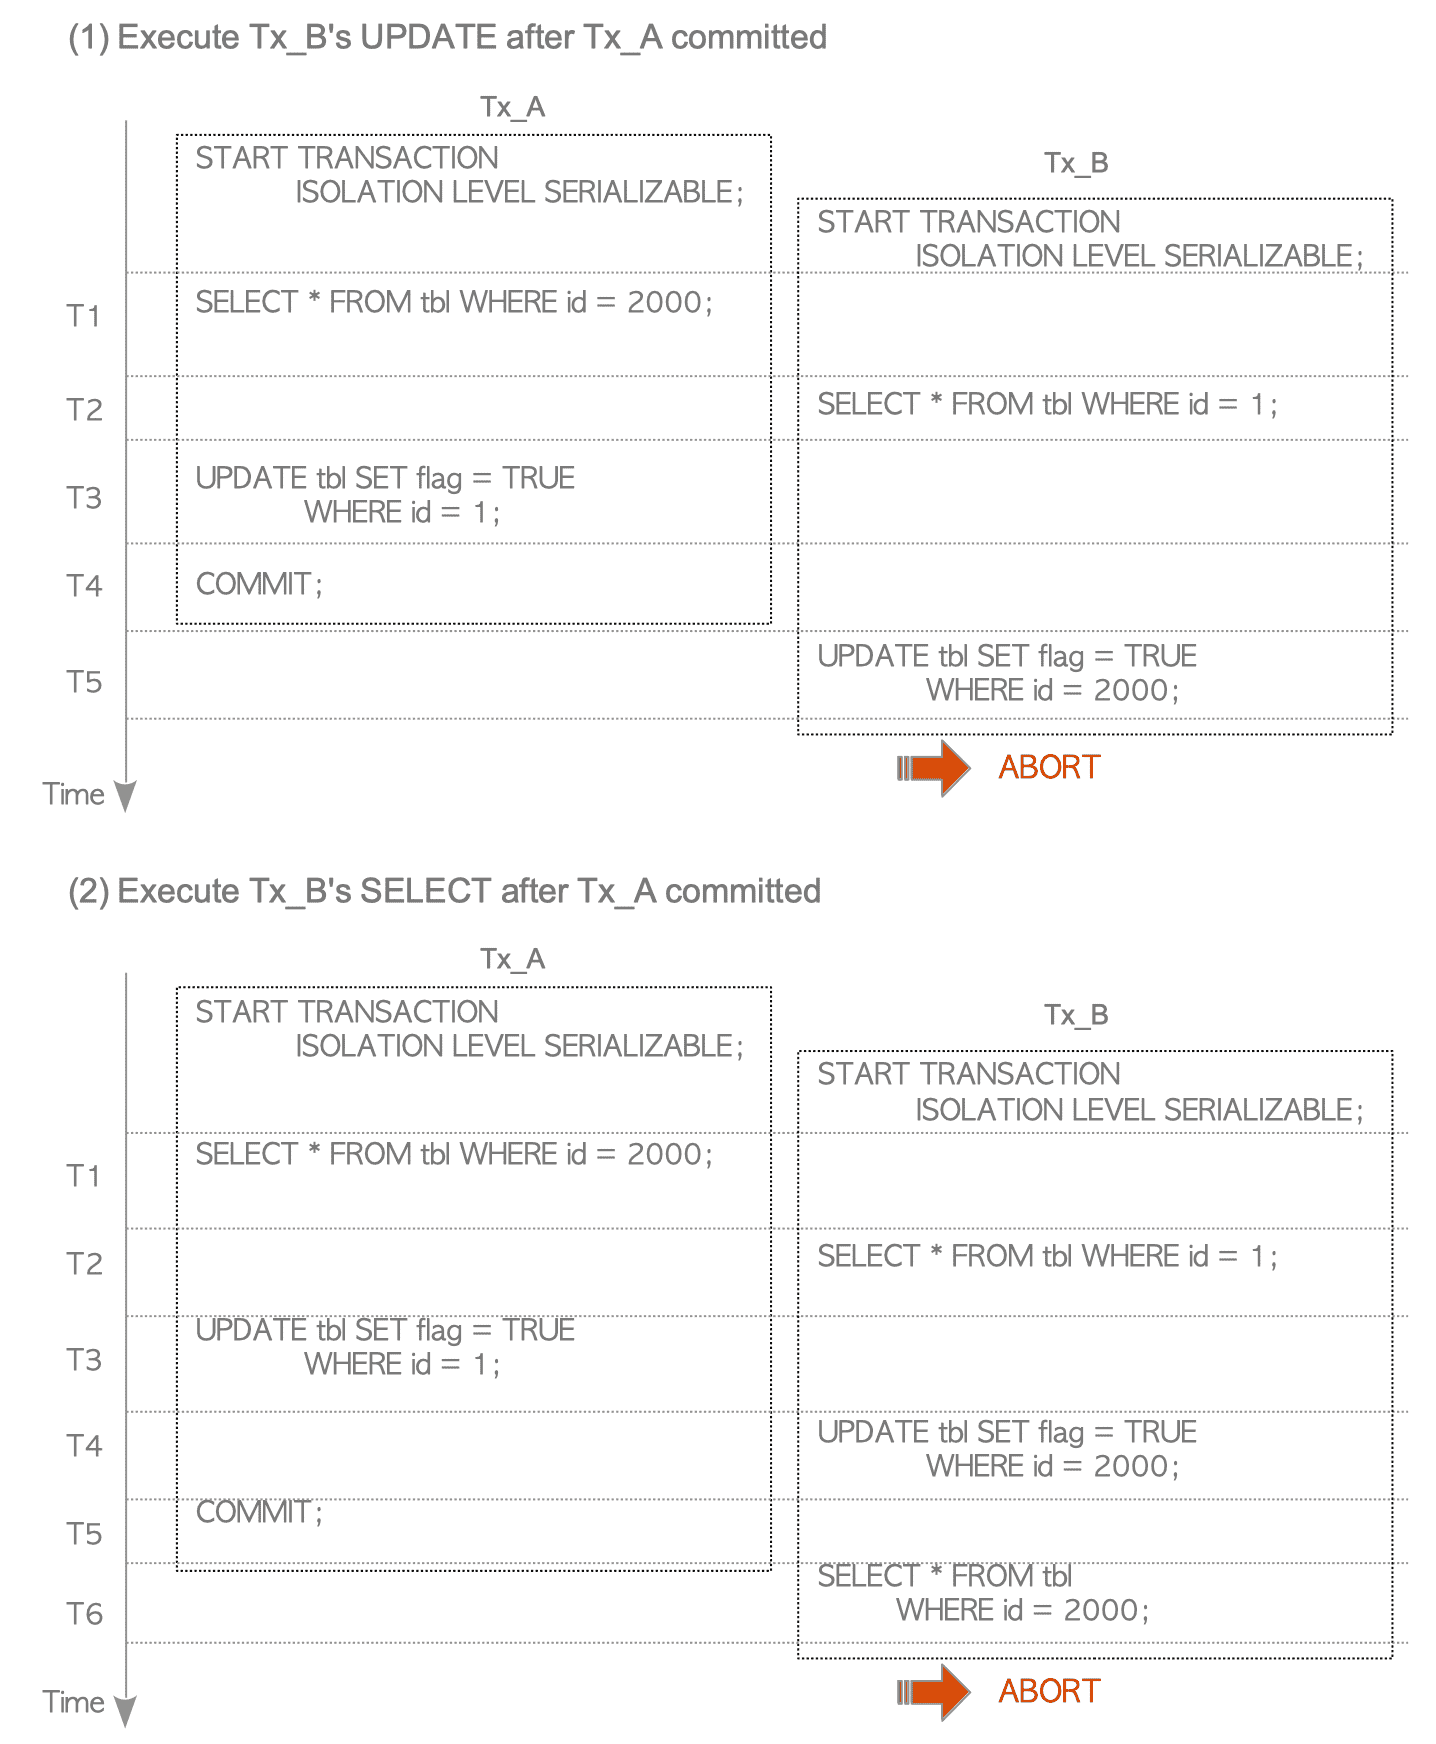

# **False-Positive Serialization Anomalies**

- SERIALIZABLE 모드에서는 거짓 부정 직렬화 예외가 감지되지 않으므로 동시 트랜잭션의 직렬화 가능성이 항상 완벽하게 보장.
- 그러나 일부 상황에서는 잘못된 긍정 오류가 감지될 수 있음.
- 따라서 사용자는 SERIALIZABLE 모드를 사용할 때 이 점을 염두에 두어야 함.
- 다음에서는 PostgreSQL이 거짓양성 이상을 감지하는 상황을 설명.

**False-Positive Scenario 1.**

- 그림은 거짓 긍정 직렬화 이상이 발생하는 시나리오를 보여줌.

**Scenario where false-positive serialization anomaly occurs.**

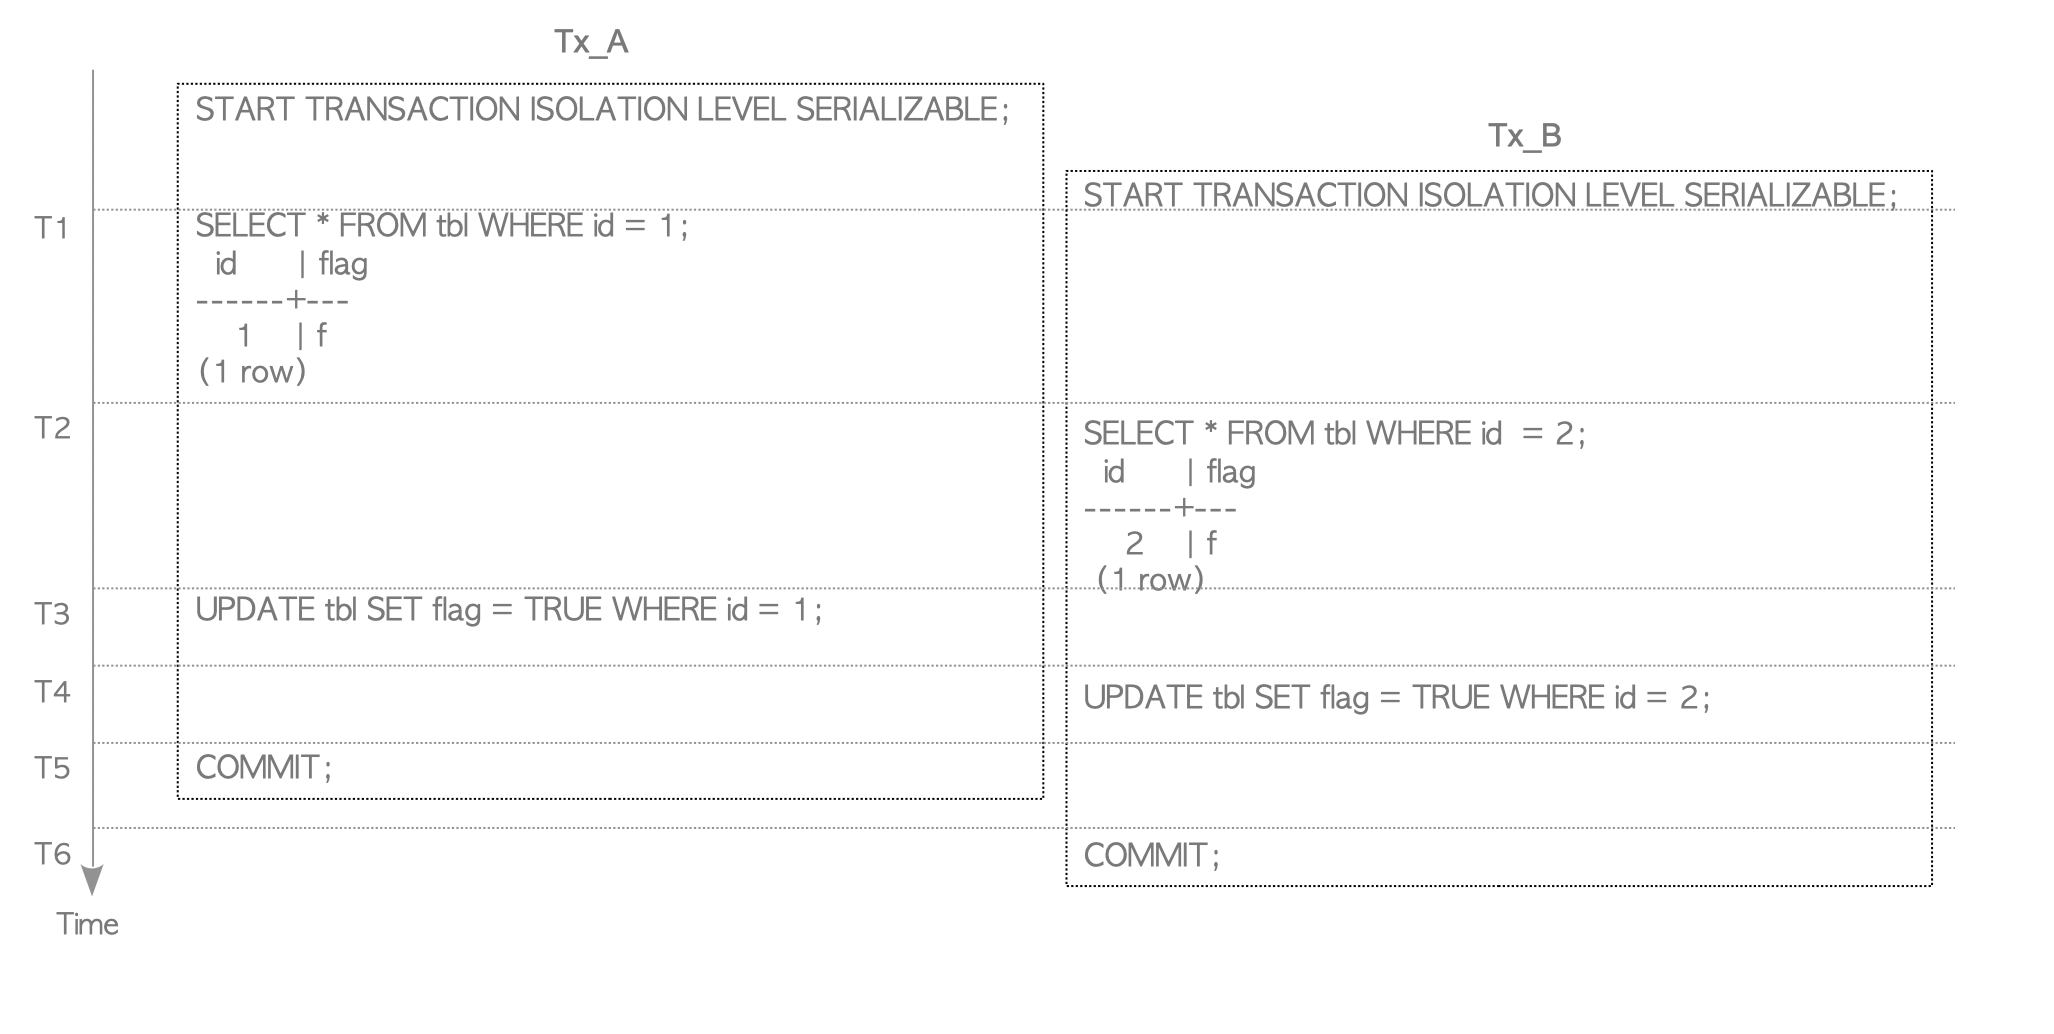

- SIREAD 잠금 설명에서 언급했듯이 순차 스캔을 사용할 때 PostgreSQL은 관계 수준 SIREAD 잠금을 생성.
- 그림은 PostgreSQL이 순차 스캔을 사용할 때 SIREAD 잠금 및 rw conflicts 을 보여줌.
- 이 경우 tbl의 SIREAD 잠금과 관련된 rw conflicts  C1 및 C2가 생성되고 선행 그래프에 주기가 생성
- 따라서 거짓 긍정 Write-Skew 이상 현상이 감지됨(conflicts 이 없더라도 Tx_A 또는 Tx_B가 중단됨).



**False-positive anomaly (1) - Using sequential scan.**

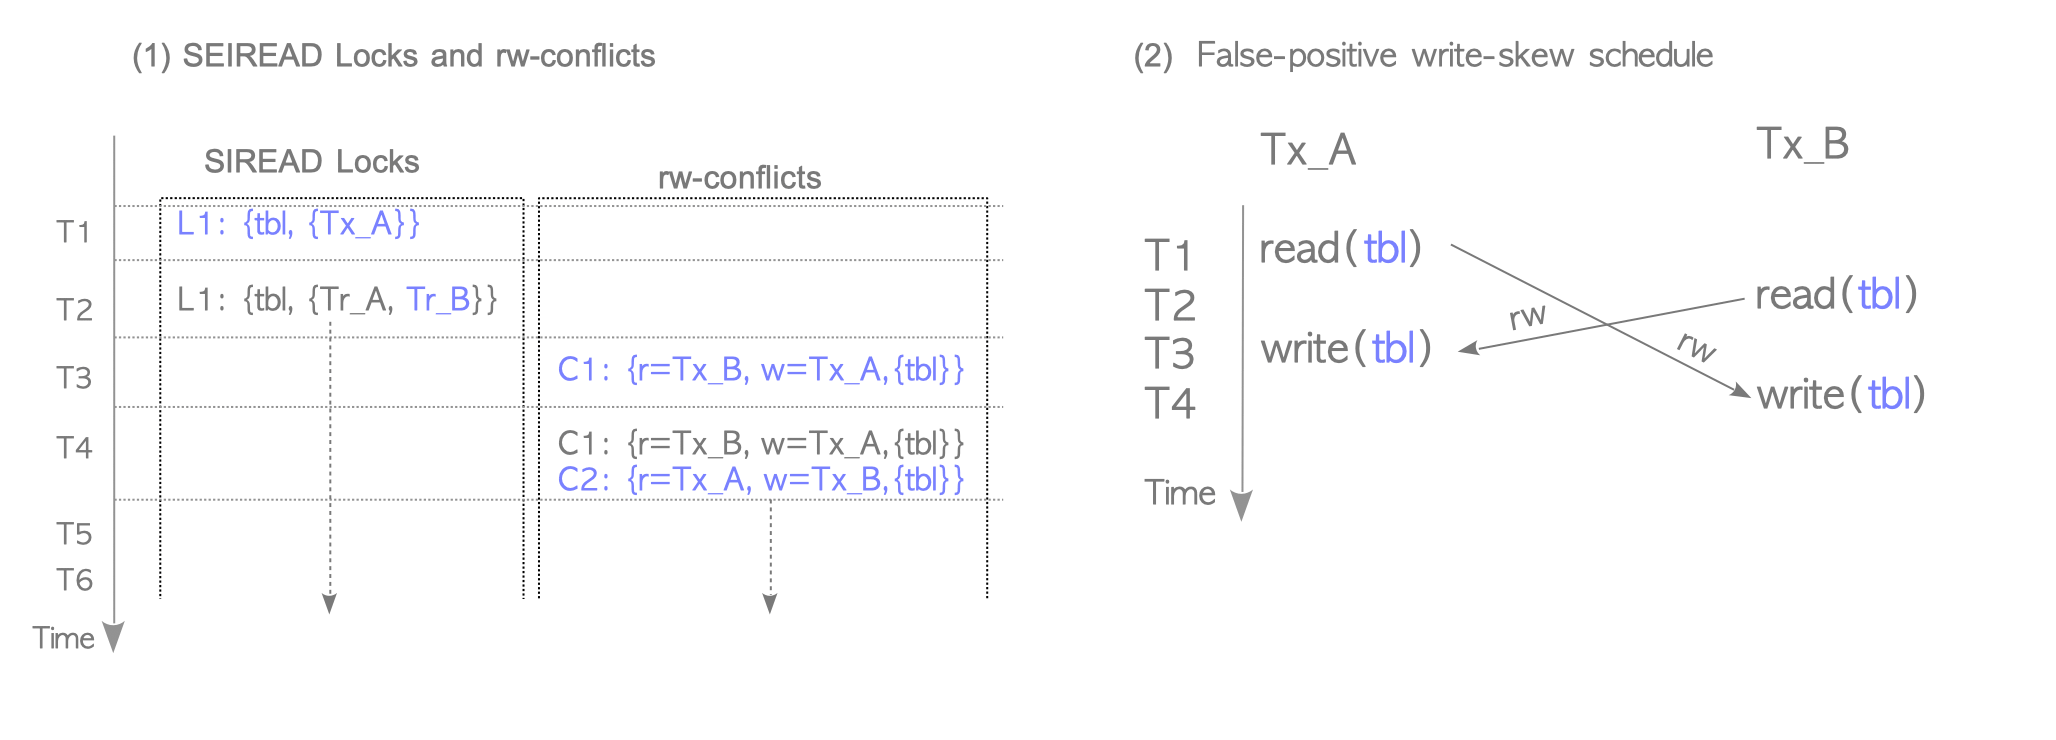

**False-Positive Scenario 2.**

- 인덱스 스캔을 사용하는 경우에도 Tx_A 및 Tx_B 트랜잭션 모두 동일한 인덱스 SIREAD 잠금을 받으면 PostgreSQL은 거짓 긍정 이상을 감지.
- 그림은 이러한 상황을 보여줌.

**False-positive anomaly (2) - Index scan using the same index page.**

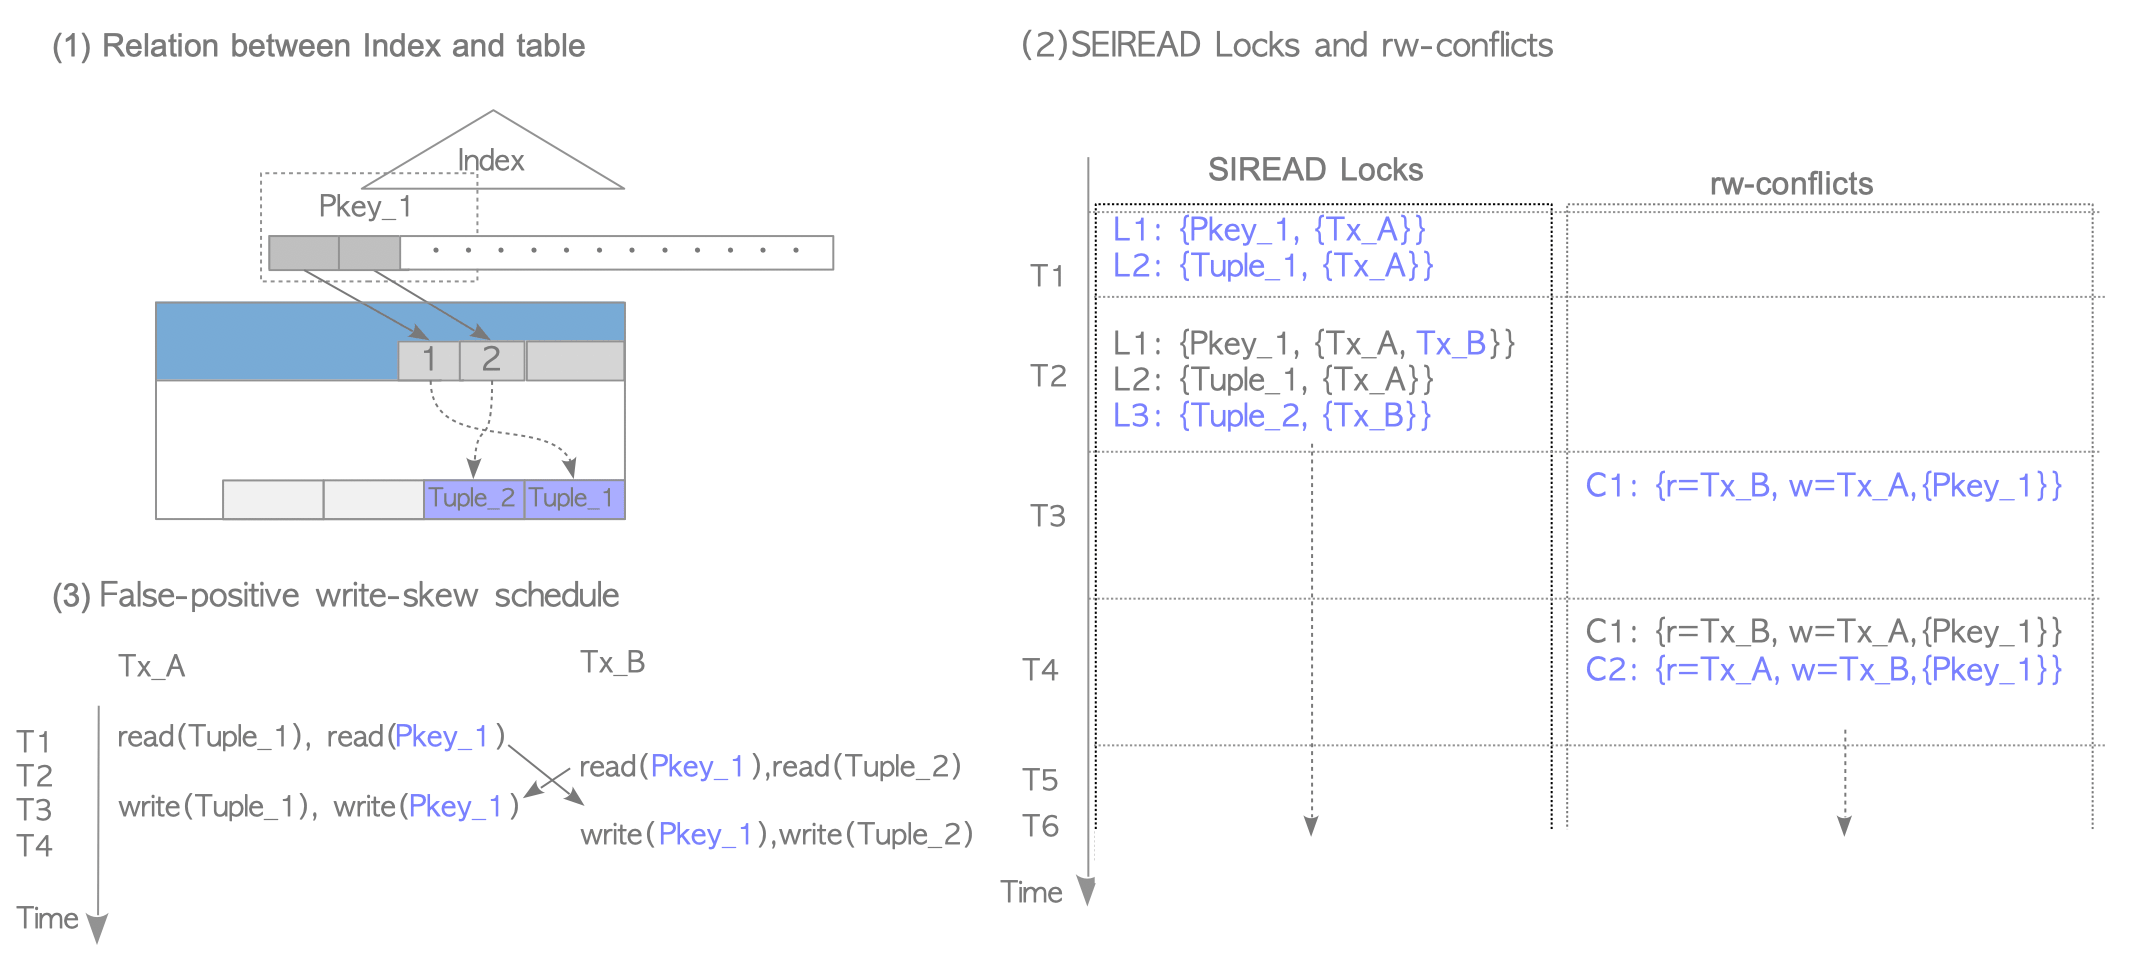

- 인덱스 페이지 Pkey_1에 두 개의 인덱스 항목이 포함되어 있는데 그 중 하나는 Tuple_1을 가리키고 다른 하나는 Tuple_2를 가리킨다고 가정.

- Tx_A와 Tx_B가 각각 SELECT 및 UPDATE 명령을 실행할 때 Pkey_1은 Tx_A와 Tx_B 모두에서 읽고 씀.
- 이 경우, 둘 다 Pkey_1과 연관된 rw 충돌 C1 및 C2는 우선순위 그래프에 순환을 생성
-  따라서 거짓 긍정 Write-Skew 이상 현상이 감지됨.

- (Tx_A와 Tx_B가 서로 다른 인덱스 페이지의 SIREAD 잠금을 받으면 거짓 긍정이 감지되지 않으며 두 트랜잭션 모두 커밋될 수 있음.)